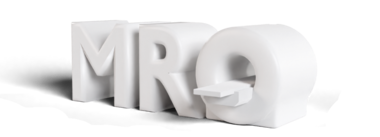

# **FID: free induction decay**
In this script a sequence and a phantom are set-up to simulate the measurement of the free induction decay signal.

References:
1.   https://mriquestions.com/free-induction-decay.html, last access: 16-05-2024



## 1. Library installation and download of phantom

In [ ]:
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

## 2. Library import and setup

In [ ]:
import numpy as np
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

## 3. Acquisition configuration

In [ ]:
# Phantom resolution
sz = [64, 64]

# Field of view, imaging volume and resolution
fov = 200e-3
slice_thickness = 8e-3
Nread = 64
Nphase = 64

# Sequence's name
experiment_id = 'flash'
save = True

# Scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m',
    max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6,
    grad_raster_time=50e-6
)

## 4. Phantom loading and configuration

In [ ]:
# Load phantom data
obj_p = mr0.VoxelGridPhantom.load('../../quantified_brain.npz')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)

# Manipulate loaded data
obj_p.D *= 0
obj_p.plot()

## 5. Sequence building

In [ ]:
def flash_2D(fov=200e-3, slice_thickness=8e-3,
             n_read=64, n_phase=64,
             system=system,
             flip_angle=10, phase_cycling=84):
    """Linear, cartesian 2D FLASH with TR = 26 ms + 50 us * n_phase"""
    rf, gz, gzr = pp.make_sinc_pulse(
        flip_angle=flip_angle * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        return_gz=True, system=system
    )

    adc_dur = n_phase * 50e-6
    gx = pp.make_trapezoid(channel='x', flat_area=n_read / fov, flat_time=adc_dur, system=system)
    adc = pp.make_adc(num_samples=n_read, duration=adc_dur, delay=gx.rise_time, system=system)
    gx_pre = pp.make_trapezoid(channel='x', area=-0.5 * gx.area, duration=5e-3, system=system)
    gx_spoil = pp.make_trapezoid(channel='x', area=1.5 * gx.area, duration=2e-3, system=system)

    seq = pp.Sequence(system)
    for i in range(n_phase):
        phase = 0.5 * phase_cycling * (2 + i + i**2)
        rf.phase_offset = (phase % 360) * np.pi / 180
        adc.phase_offset = rf.phase_offset

        phenc = (i - n_phase // 2) / fov

        seq.add_block(rf, gz)
        seq.add_block(gzr, pp.make_delay(5e-3))
        gp = pp.make_trapezoid(channel='y', area=phenc, duration=5e-3, system=system)
        seq.add_block(gx_pre, gp)
        seq.add_block(adc, gx)
        gp = pp.make_trapezoid(channel='y', area=-phenc, duration=5e-3, system=system)
        seq.add_block(gx_spoil, gp)
        seq.add_block(pp.make_delay(10e-3))

    seq.set_definition('FOV', [fov, fov, slice_thickness])
    return seq
seq = flash_2D(fov, slice_thickness, Nread, Nphase, system)
seq.set_definition('Name', experiment_id)
seq.write(experiment_id + '.seq')

# Verify sequence timing
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

## 6. Simulation

### 6.1 Update phantom parameters for simulation

In [ ]:
#@markdown  The B0 inhomogeneity brings you from the rotating frame FID at dB0=0, closer to the lab frame FID at dB0=B0.
#@markdown Try dB0=0 and dB0=500 for a test.
dB0 = 0 #@param {title:'dB0',type:"slider", min:0, max:500, step:10}

# Reload phantom
obj_p = mr0.VoxelGridPhantom.load('../../quantified_brain.npz')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)

# Manipulate loaded data
obj_p.D *= 0
obj_p.B0 += dB0
obj_p.plot()
# Convert phantom into simulation data
obj_p = obj_p.build()

### 6.2 Read seq file and simulate

In [ ]:
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')

# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# Plot sequence with SIGNAL
sp_adc, t_adc = mr0.util.pulseq_plot(seq=seq,signal=signal.numpy())

## 7. Save results

In [ ]:
if save:
    dir = "../results/"
    np.savetxt(dir + experiment_id + "_signal.txt", signal)
    plt.savefig(dir + experiment_id + "_signal.png")